In [1]:
# importing packages

In [1]:
%%capture
!pip install ruptures
!pip install saxpy
!pip install tsfresh

In [5]:
%%capture
!pip install matplotlib
!pip install seaborn


In [7]:
# basic packages 
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# package for change point detection 
import ruptures as rpt

# package for SAX
from saxpy.hotsax import *
from saxpy.sax import sax_via_window

# package for feature training 
import tsfresh

# sklearn packages
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans

# set global variables about the time-zone (used by pandas and matplotlib)
TZ_LOCAL = 'Europe/Zurich'
plt.rcParams['timezone'] = TZ_LOCAL
plt.rcParams['figure.dpi'] = 100

#### 2.2 Importing the data

Next, we import some smart meter data in 15-minute resolution, which will serve as an example in this tutorial. This data comes from real households in Switzerland and is provided by a local utility company. We have four households, each with two separate smart meters. All households have a heat pump installed for heating purposes, which is measured by one separate smart meter. All other appliances are measured by the second smart meter. In addition to the smart meter data, we also load temperature measurements from a nearby weather station. We will use this data in later sections of this tutorial.



In [10]:
# ---------------------
# DEFINE HELPER METHODS 
# ---------------------

def load_remote_data(url, filename, index_col): 
    '''
    Loads the data from an URL and file name. 
    Args: 
      url: Google Drive URL to file
      filename: name of file 
      index_col: the column name to set the index to 
    Returns: 
      data frame 
    '''
    # if the data is not yet downloaded, retrieve it by URL
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)
    
    # load data with pandas 
    df = pd.read_csv(filename, index_col=index_col)
    return df

def handle_timezones(df_smd, df_weather_daily, df_weather_hourly): 
    '''
    Sets local timezones on data frames of smart meter and weather data. 
    Args: 
      df_smd: data frame holding smart meter data
      df_weather_daily: data frame holding daily temperature readings 
      df_weather_hourly: data frame holding hourly temperature readings 
    '''
    # df_smd.index = pd.to_datetime(df_smd.index, format='%Y-%m-%d %H:%M:%S').tz_convert(TZ_LOCAL)
    df_smd.index = pd.to_datetime(df_smd.index, format='mixed').tz_convert(TZ_LOCAL)
    df_weather_daily.index = pd.to_datetime(df_weather_daily.index, format='%Y-%m-%d').tz_localize('UTC')
    df_weather_hourly.index = pd.to_datetime(df_weather_hourly.index, format='%Y-%m-%d %H:%M:%S').tz_localize('UTC').tz_convert(TZ_LOCAL)

def get_household_file_ids(customer_number): 
    '''
    For each customer defines the file-IDs in Google Drive. 
    Args: 
      customer_number: integer between 1 and 4 to identify the four example customers 
    Returns: 
      dictionary with file IDs for smart meter data, daily weather, and hourly weather
    '''
    return {
      1 : {'customer1_smd' : '1bQaj4Gu_rCHxKa1fQuu-yNp7ceCIrPbb', 'customer1_weather_daily' : '1qM2YguM7Ij3LHkPwplLSFQTEdYedjQ9y', 'customer1_weather_hourly' : '1qjDkM3TPmaeNEPHWMPgCkobbRVLpgcxc'},
      2 : {'customer2_smd' : '1swUbaR1960i46AGXHp1ZL3KV1uI44Kd8', 'customer2_weather_daily' : '1WQUAlz4AsMqjsg33rwoRyPko9qNHkiMz', 'customer2_weather_hourly' : '1b_Nk0gYKESw5EeBImICbg7uiIpNOpXe6'},
      3 : {'customer3_smd' : '1Cmv_oRtHx5PlHadaXhA2aqmmEOpNCnqB', 'customer3_weather_daily' : '15ErtjTLiKKMaBOv68HTgxbZ5fPEnsswF', 'customer3_weather_hourly' : '1nYOv-55n2DFpQYbcS88V2zL8-xCLlHr6'},
      4 : {'customer4_smd' : '1keacAOQGpPFYVM2MhQdaO-3c0DVtcsXl', 'customer4_weather_daily' : '1EddXm10v26MGlb0pYJgaaqemCTLGtlc_', 'customer4_weather_hourly' : '1PXdmlEZKt0mNbLJ7fWReJgmRPOAVh6EM'}
    }[customer_number]

def get_download_information(customer_number): 
    '''
    For each customer get the file names and URLS for data download from Google Drive. 
    Args: 
      customer_number: integer between 1 and 4 to identify the four example customers 
    Returns: 
      dictionary with file names as keys and URLs as values 
    '''
    d = {}
    for k, v in get_household_file_ids(customer_number).items(): 
        d[k+'.csv'] = 'https://drive.google.com/uc?id={}&export=download'.format(v)
    return d 

def load_customer_data(customer_number): 
    '''
    Loads the smart meter data, daily and hourly temperature readings for each of the four customers.
    Args: 
      customer_number: integer between 1 and 4 to identify the four example customers 
    Returns: 
      sequence of df with smart meter, df with daily weather, df with hourly weather
    '''
    assert customer_number in range(1, 5), 'Customer number must be one of the following integers: 1, 2, 3, 4'
    d = get_download_information(customer_number)
    customer_id = 'customer{}_'.format(customer_number)
    
    # fetch data 
    df_smd = load_remote_data(d[customer_id+'smd.csv'], customer_id+'smd.csv', 'Timestamp')
    df_weather_daily = load_remote_data(d[customer_id+'weather_daily.csv'], customer_id+'weather_daily.csv', 'date') 
    df_weather_hourly = load_remote_data(d[customer_id+'weather_hourly.csv'], customer_id+'weather_hourly.csv', 'date_and_time') 
    
    # handle time zones 
    handle_timezones(df_smd, df_weather_daily, df_weather_hourly)
    
    return df_smd, df_weather_daily, df_weather_hourly

# ---------------------
# LOAD DATA  
# ---------------------
customer = 4 # must be an integer - can be: 1, 2, 3, 4
df_smd, df_weather_daily, df_weather_hourly = load_customer_data(customer)
print('Loaded Data successfully for customer: {}'.format(customer))

Loaded Data successfully for customer: 4


In [12]:
df_smd.head()

,Value,Value_HeatPump,Value_OtherAppliances
Timestamp,,,
2019-11-20 00:00:00+01:00,0.736,0.682,0.054
2019-11-20 00:15:00+01:00,1.216,1.126,0.090
2019-11-20 00:30:00+01:00,0.488,0.450,0.038
2019-11-20 00:45:00+01:00,0.065,0.023,0.042
2019-11-20 01:00:00+01:00,0.650,0.608,0.042


Let's take a look at the data frame that contains the smart meter data.
The index of the frame contains the timestamps of the measurements.
There are three columns of energy values that reflect the total consumption in kilowatt hours (kWh) for each 15-minute time interval:
- **Value_HeatPump:** Consumtion of the heat pump measured by one smart meter
- **Value_OtherAppliances:** All other consumption in the household measured by a second smart meter
- **Value:** Sum of both measurements reflecting the total consumption

For now we will focus on the **total consumption**.

In addition, for [later use in the context of clustering](#clustering_algorithms), we **load data of average daily profiles that we extracted for a few hundred households**.

In [13]:
url = 'https://drive.google.com/uc?id=1bKNvlzOmm9063D-rgxC2lX1W8J-3zE5M&export=download'
df_profiles = load_remote_data(url, 'profiles.csv', 'id') 
display(df_profiles)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
id,,,,,,,,,,,,,,,,,,,,,
05799b091d77acb8963bc4f189cbbc94,0.021,0.020,0.018,0.015,0.014,0.014,0.013,0.012,0.013,0.013,...,0.056,0.054,0.044,0.040,0.037,0.033,0.029,0.024,0.023,0.022
057c30dbdc165d5dbc8dfaba85be5be7,0.566,0.557,0.799,0.908,0.822,0.770,0.658,0.609,0.934,0.931,...,0.040,0.040,0.581,0.752,0.773,0.782,0.713,0.563,0.470,0.528
057c3fcbdcbfd97b9f8a50fb34f385d6,0.014,0.013,0.013,0.015,0.015,0.013,0.013,0.015,0.015,0.014,...,0.037,0.034,0.033,0.034,0.032,0.029,0.025,0.024,0.021,0.018
057d57d2e17e556e76045ec53f58beb2,0.459,0.342,0.286,0.342,0.900,0.858,0.660,0.592,0.521,0.160,...,0.113,0.180,0.727,0.723,0.719,0.529,0.431,0.471,0.488,0.518
057d990ed2aee058d63f15f30443f9e4,0.631,0.624,0.624,0.620,0.629,0.634,0.632,0.634,0.638,0.632,...,0.632,0.618,0.612,0.617,0.624,0.622,0.624,0.634,0.632,0.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a42793c65fddea7c1f8228f8d4742635,0.086,0.126,0.101,0.084,0.093,0.082,0.082,0.087,0.079,0.075,...,0.166,0.163,0.176,0.193,0.166,0.136,0.142,0.068,0.058,0.069
a427d8292c36aadbf48269008ce844b3,0.620,0.480,0.437,0.522,0.842,0.413,0.439,0.400,0.406,0.353,...,0.476,0.593,0.847,0.579,0.580,0.537,0.632,0.433,0.415,0.438
a428b13bc581d14804c35c1f6b4169be,2.800,3.114,3.097,2.848,2.614,2.765,2.877,3.013,3.371,2.895,...,0.441,0.629,0.974,1.541,1.746,1.910,1.880,2.270,2.557,2.546


<a name=visualizing_smd></a>
# **3. Best practices for visualizing smart meter data** 🎨

Now that the data is loaded, let's examine it and get a feel for it. Instead of just printing out the values, it is very useful to display them graphically. This allows us to see patterns and behaviors quickly and intuitively. So here are some starting points and best practices for visualizing smart meter data.

<a name=time_series_visualizations></a>
### **3.1 Time-series visualizations of energy data**

The easiest way to display the data is in a **one-dimensional line chart** that shows the entire time span.
It is easy to see the range of data availability as well as the maximum values.
Large-scale trends within the data can also be seen.
However, this **visualization is too dense to observe more detailed behavior** and relate it to specific timestamps.

To solve this problem, we calculate the total energy consumption on each day and reduce the number of data points by a factor of $24h / 15min = 96$. Now we can see clear trends across seasons.

We can also reduce the density of the plot by only visualizing one week of data. Here we can see regular patterns that seem to repeat each day.

Another insightful way to examine such regularities is to **calculate the mean consumption profile by averaging the consumption at each time of day** over the entire period of measurements. Here we can clearly see a peak of increased consumption at night.

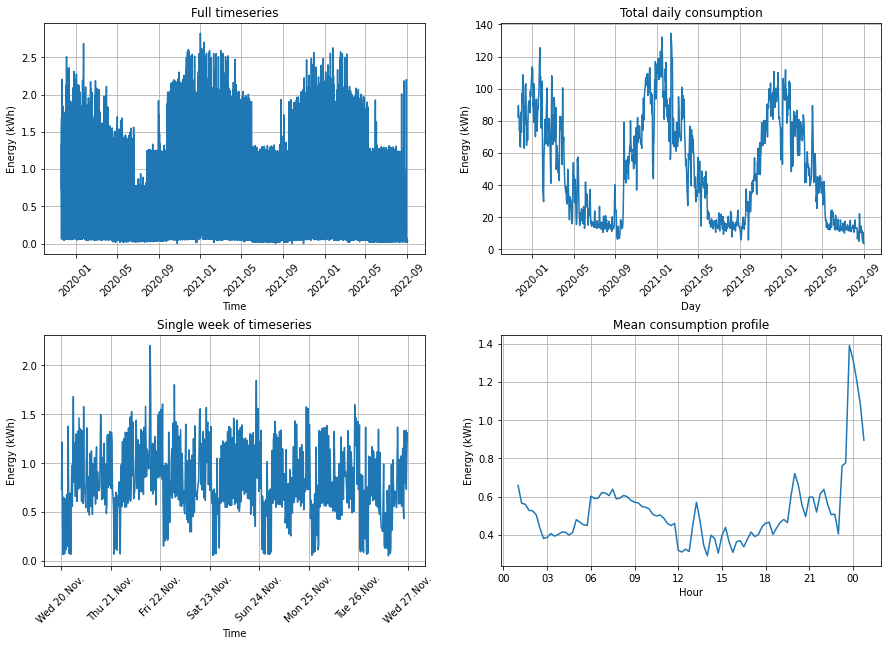

In [14]:
# ------------------------
# DEFINE HELPER FUNCTIONS
# ------------------------

def plot_data(ax, df, column='Value'):
  if column is None:
    ax.plot(df)
  else: 
    ax.plot(df[column])
  ax.xaxis.set_tick_params(rotation=45)
  ax.set_xlabel('Time')
  ax.set_ylabel('Energy (kWh)')
  ax.grid()

def calculate_daily_consumption(df, column='Value'):
  return df.groupby([df.index.date])[column].sum()

def plot_daily_consumption(ax, df):
  # Divide by 4 to convert 15 Wmin to 1 Wh
  ax.plot(df)
  ax.xaxis.set_tick_params(rotation=45)
  ax.set_xlabel('Day')
  ax.set_ylabel('Energy (kWh)')
  ax.set_title('Total daily consumption')
  ax.grid()

def calculate_mean_profile(df, column='Value'):
  mean_profile = df.groupby([df.index.time])[column].mean()
  mean_profile.index = mean_profile.index.map(lambda t: dt.datetime.combine(dt.datetime(year=1970, month=1, day=1), t))
  return mean_profile

def plot_mean_profile(ax, mean_profile):
  ax.plot(mean_profile)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
  ax.set_xlabel('Hour')
  ax.set_ylabel('Energy (kWh)')
  ax.set_title('Mean consumption profile')
  ax.grid()

# ------------------------
# CREATE THE GRAPHS
# ------------------------

# define a figure with two columns and two rows
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.35)

# plot first graph 
plot_data(ax[0, 0], df_smd)
ax[0, 0].set_title('Full timeseries')

# plot the second graph
plot_daily_consumption(ax[0, 1], calculate_daily_consumption(df_smd))

# plot the third graph
plot_data(ax[1, 0], df_smd.iloc[:96 * 7, :])
ax[1, 0].set_title('Single week of timeseries')
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%b."))
ax[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())

# plot the fourth graph
plot_mean_profile(ax[1, 1], calculate_mean_profile(df_smd))

<a name=visualizing_distributions></a>
### **3.2 Visualizing distributions of energy consumption**

While it is very interesting to observe the evolution of energy consumption over time, it can also be informative to analyze **how often how much energy is consumed, i.e. the histogram of the values in the time series**.

In most cases, consumption is very low and the distribution falls off rapidly as energy increases.
However, there are peaks in the distribution that indicate recurring measurements with the same energy. These are indications of regularly running devices (see [later section](#distributional_peak_detection) in the context of pre-processing).

Plotting the distribution with a logarithmic scale of the y-axis reveals peaks with lower counts at higher energy.

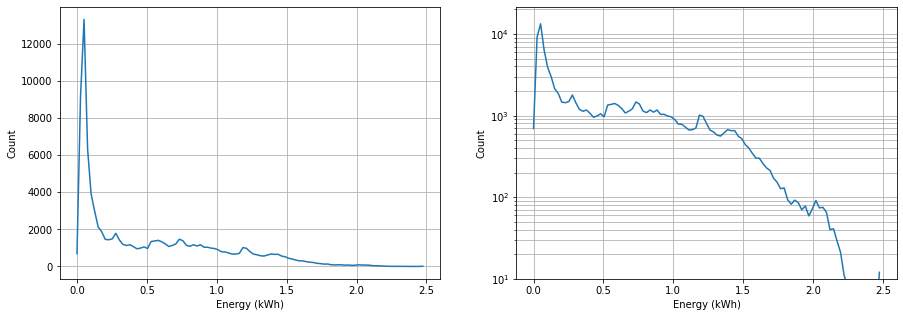

In [15]:
# define the energy intervals to use for the histogram
bins = np.linspace(0, 2.5, 100)

# calculate the distribution of energy values
df_smd_hist, _ = np.histogram(df_smd['Value'], bins=bins)

# define a figure with two columns
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# plot the histogram
ax[0].plot(bins[:-1], df_smd_hist)
ax[0].set_xlabel('Energy (kWh)')
ax[0].set_ylabel('Count')
ax[0].grid()

# plot the histogram on a logarithmic scale
ax[1].plot(bins[:-1], df_smd_hist)
ax[1].set_yscale('log')
ax[1].set_ylim(10, None)
ax[1].set_xlabel('Energy (kWh)')
ax[1].set_ylabel('Count')
ax[1].grid(which='both')

<a name=multidimensional_visualizations></a>
### **3.3 Multi-dimensional visualizations**

The simple line graphs can be advantageous for plotting average data or short periods of time (e.g., a few days). However, observing longer periods in this way is difficult due to the density of the measurements. In the case of smart meter data, we are particularly interested in observing the behavior of prominent appliances and their regular on/off switching per day. **Heatmaps** are a very powerful method to visualize the corresponding time series patterns in a multidimensional way. 

To achieve this, we **divide** each timestamp into day and time, which can be interpreted as transferring time in one dimension into a **two-dimensional space**. Consequently, the axes of the heatmap are as follows: 
- **x-axis:** shows the date in chronological order from left to right.
- **y-axis:** shows the time of day in chronological order from top to bottom.

Now you can interpret the area spanned by x and y as a canvas that you can color according to the patterns generated by the smart meter data: 
- The **position of each pixel** in the canvas is indicated by the date and time (i.e., the timestamp). 
- The **color of each pixel** is defined by a mapping of the energy consumption at the given time to a continuous color scale. 

Let's take a look at what that looks like!

/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/908332553.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


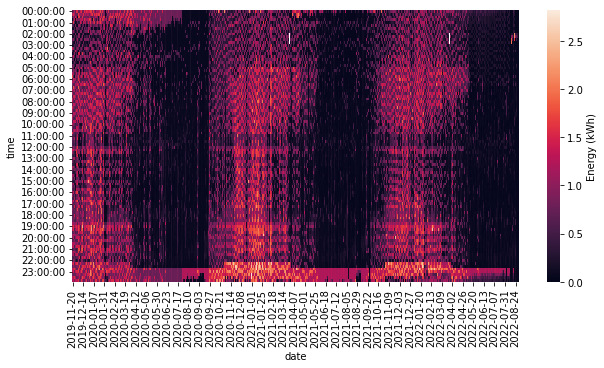

In [17]:
# ------------------------
# DEFINE HELPER FUNCTION
# ------------------------

def create_heatmap(df, column, interval_minutes=15):
  # As we will add additional columns and do not want the original data to be affected, create copy of the original data frame
  data_df = df.copy()
  # Add columns for date and time
  data_df["date"] = df.index.date
  data_df["time"] = df.index.time
  # Define a function that handles duplicate values which can occur in local time due to daylight savings time
  # Using only the first datapoint instead of summing avoids unrealistically height demand 
  get_first = lambda x: x.iloc[0]
  # Pivot dates and times to create a two dimensional representation
  data = data_df.pivot_table(index='time', columns='date', values=column, aggfunc=get_first, dropna=False)
  return data

# ------------------------
# CREATE THE FIGURE
# ------------------------

hm = create_heatmap(df_smd, column='Value')

fig_hm, ax_hm = plt.subplots(1, 1, figsize=(10, 5))
# Seaborn has a function to plot the dataframe including time labels for the axes
sns.heatmap(hm, ax=ax_hm, cbar_kws={'label': 'Energy (kWh)'})

fig.show()

Now we can see **patterns in the data over the entire time span** across both, seasons and hours of the day:
- activity is higher in winter than in summer because there is no heating in summer
- there seems to be a device that turns on very regularly every day
- the checkerboard pattern especially visible in winter is caused by a heat pump *(check out [6] if you want to learn more about its patterns in smart meter data)*.

We can also **visualize the heatmap data in a three-dimensional representation** that makes the consumption peaks even clearer.

/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/635403222.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


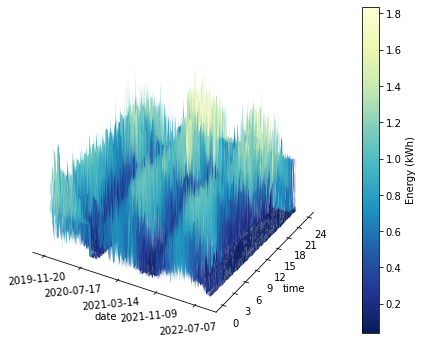

In [18]:
# create a 3d figure
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='3d')

# Create meshgrid
X, Y = np.meshgrid(np.arange(hm.shape[1]), np.arange(hm.shape[0]))

# Plot the surface
plot = ax.plot_surface(X=X, Y=Y, Z=np.nan_to_num(hm.values), cmap='YlGnBu_r')

# set tick every three hours for the time axis
ax.set_yticks(ticks=range(0, 97, 3 * 4))
ax.set_yticklabels(labels=range(0, 25, 3))
ax.set_ylabel('time')

# set ticks for the date axis based on the heatmap above
ax.set_xticks(ax_hm.get_xticks()[::10])
ax.set_xticklabels(ax_hm.get_xticklabels()[::10], rotation=5)
ax.set_xlabel('date')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)
# Remove z-axis
ax.zaxis.line.set_lw(0.)
ax.set_zticks([])
# ax.set_zlabel('Energy (kWh)')

fig.colorbar(plot, ax=ax, label='Energy (kWh)')

fig.show()

<a name=annotating_visualizations></a>
### **3.4 Annotating visualizations with additional context information**

To add **more useful information** to the figure, we enter the daily consumption previously studied and the average consumption profile along the x- and y-axes, respectively.
We also enter the times of sunrise and sunset on each day (as white lines in the heatmap), as these may be related to energy consumption for lighting and heating.
The upper insert shows the daily energy consumption (gray area) and the daily peak demand (black dots).
The right insert shows the average demand profile.

Since this figure requires quite a bit of code, we import a small script with some helper functions that we provide separately.

In [19]:
# Clean up and download fresh version of the script
!rm -rf /content/iclr-smartmeteranalytics
!git clone --depth 1 https://github.com/bitstoenergy/iclr-smartmeteranalytics
import sys
# Add the script to the library path
sys.path.append('iclr-smartmeteranalytics')
import smartmeteranalytics as sma

Cloning into 'iclr-smartmeteranalytics'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/248196538.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


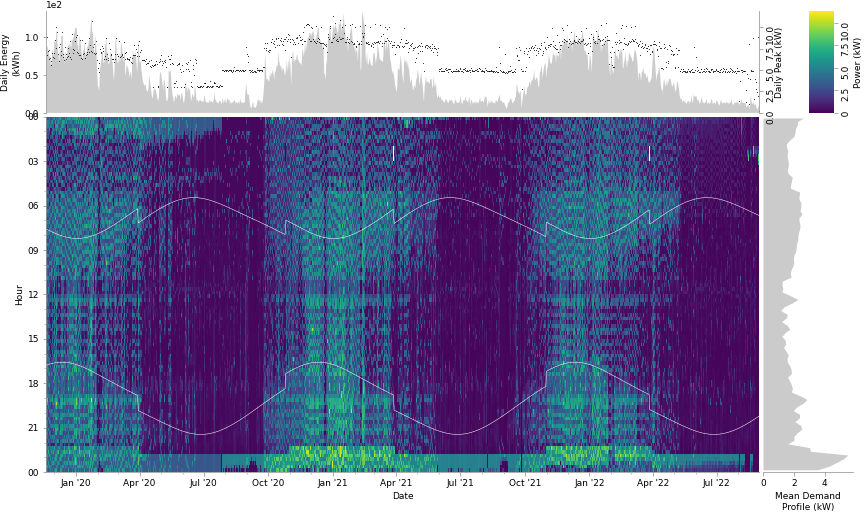

In [20]:
df_smd_filled = df_smd.asfreq("15min", fill_value=pd.NA) * 4  # convert to power
fig = sma.HeatmapFigure(df_smd_filled, 'Value', figsize=(14, 8))
fig.show()

<a name=displaying_aggregated_demand></a>
### **3.5 Displaying aggregated demand**

Remember that the data frame contains not only the total consumption measured at the meter, but also two columns containing **separate measurements for the heat pump and all other appliances**.

When dealing with multiple time series, a **stacked area graph** can be interesting to visualize the individual data and their contribution to the combined consumption.
As an example, we show again the daily demand, while the other graphs from above can be easily created in a similar way.

In other situations, this type of visualization can also be useful when processing data from multiple households, for example, to analyze their consumption relative to the total demand at a transformer station.

/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/2700377145.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


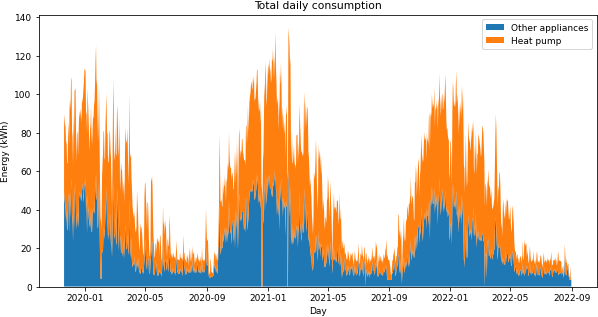

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# calculate the daily demand of the heat pump and the other appliances
daily_hp = df_smd.groupby([df_smd.index.date])['Value_HeatPump'].sum()
daily_other = df_smd.groupby([df_smd.index.date])['Value_OtherAppliances'].sum()

# create the stacked plot
ax.stackplot(daily_other.index, daily_other, daily_hp, labels=['Other appliances', 'Heat pump'])

ax.set_xlabel('Day')
ax.set_ylabel('Energy (kWh)')
ax.set_title('Total daily consumption')
ax.legend()
fig.show()

<a name=preprocessing_smd></a>
# **4. Pre-processing smart meter data** 🛠️

In some cases, it may be necessary to pre-process the data for analysis. In this section we present some best practices to be used in later sections.

<a name=combining_smd_weather></a>
### **4.1 Combining smart meter data with temperature data**

In order to interpret energy data correctly, a link to the local weather is often required. For example, if a building is heated or cooled electrically, the energy consumption often depends strongly on the outside temperature. Similarly, the energy consumption of a building with a photovoltaic (PV) system is most likely affected by the hours of sunshine on each day. Smart meter data and weather data often come from different data sources. Therefore, we will now show you how to merge **weather and energy data into one data frame**, which can facilitate any analysis.

- **Remember** that in a [section at the beginning](#data_imports) you have loaded not only the smart meter data, but also some temperature data in hourly and daily resolution. 
- **Remember** that the *df_weather_daily* data frame contains only dates as indices (YYYY-MM-DD).
- **Remember** that the data frame *df_weather_hourly* contains dates and hours as indices (YYYY-MM-DD HH).
- **Remember** that the smart meter data *df_smd* contains dates and times as indices (YYYY-MM-DD HH:MM).

Let's look at how to handle these different types of timestamps.



In [23]:
# --------------------------------
# DEFINE HELPER FUNCTION
# --------------------------------

def merge_smd_with_weather(df_smd, df_weather, hourly=False):
  '''
    Merges a weather data frame into the data frame containing the smart meter data.
    Can cope with daily and hourly weather. 
    NOTE: assumes that parameters df_smd and df_weather have the timestamps as index and that they are of type pd.datetime
    Args: 
      df_smd: the pandas data frame holding smart meter data 
      df_smd: the pandas data frame holding weather data 
      hourly: boolean to set to True if the weather data is in hourly resolution, otherwise assuming daily
    Returns: 
      copy of the SMD data frame with the weather observations merged into it as additional columns
  '''

  # as we will add additional columns and do not want the original data to be affected, create copies of the original data frames
  df_smd_copy = df_smd.copy()
  df_weather_copy = df_weather.copy()

  # for merging convert the time zones back to UTC
  df_smd_copy.index = df_smd_copy.index.tz_convert('UTC')
  df_weather_copy.index = df_weather_copy.index.tz_convert('UTC') # for merging set to UTC

  # change the index to a multi index that distinguished between date and hour
  df_smd_copy.index = pd.MultiIndex.from_arrays(arrays=[df_smd_copy.index.date, df_smd_copy.index.hour], names=['date_temp', 'hour_temp'])
  df_weather_copy.index = pd.MultiIndex.from_arrays(arrays=[df_weather_copy.index.date, df_weather_copy.index.hour], names=['date_temp', 'hour_temp'])

  # merge the weather data into the smart meter data
  # (differs for hourly and daily weather data)
  if hourly: 
    df_combined = df_smd_copy.merge(df_weather_copy, on=['date_temp', 'hour_temp'])
  else: 
    df_combined = df_smd_copy.merge(df_weather_copy, on=['date_temp'])

  # reset the index to the original index in the SMD data frame 
  df_combined.reset_index(inplace=True, drop=True) #first flatten everything 
  df_combined.index = df_smd.index # now reset the index to the original data frame 

  return df_combined

# --------------------------------
# ADDING TEMPERATURES TO SMD
# --------------------------------

# add daily temperatures
df_combined = merge_smd_with_weather(df_smd, df_weather_daily, hourly=False)

# add hourly temperatures
df_combined = merge_smd_with_weather(df_combined, df_weather_hourly, hourly=True)

display(df_combined)


,Value,Value_HeatPump,Value_OtherAppliances,daily_mintemp,daily_maxtemp,daily_avgtemp,hourly_temperature
Timestamp,,,,,,,
2019-11-20 00:00:00+01:00,0.736,0.682,0.054,0,5,3,4
2019-11-20 00:15:00+01:00,1.216,1.126,0.090,0,5,3,4
2019-11-20 00:30:00+01:00,0.488,0.450,0.038,0,5,3,4
2019-11-20 00:45:00+01:00,0.065,0.023,0.042,0,5,3,4
2019-11-20 01:00:00+01:00,0.650,0.608,0.042,2,7,4,5
...,...,...,...,...,...,...,...
2022-08-31 22:45:00+02:00,0.052,0.000,0.052,14,20,18,18
2022-08-31 23:00:00+02:00,0.035,0.000,0.035,14,20,18,17
2022-08-31 23:15:00+02:00,0.031,0.000,0.031,14,20,18,17


Now you can see that we **have** successfully merged the weather data with the smart meter data. Note that the hourly and daily weather data have lower resolution than the smart meter data. Therefore, we now have duplicate entries for each hour in the hourly weather data and for each day in the daily weather data. However, we can **use this information to calculate the correlation of energy and temperature measurements**.

In [25]:
# calculate correlation across all days
corr = stats.pearsonr(df_combined['Value'], df_combined['daily_avgtemp'])
print('Correlation across all days:', np.round(corr[0], 3))

Correlation across all days: -0.625


You can see that the energy consumption correlates negatively with the outside air temperature. Often, instead of using temperature directly, **a value is calculated that indicates whether a day is a heating day and how cold that heating day is**. This value should be zero for non-heating days (i.e., days with an average outdoor temperature above a certain heating threshold) and non-zero otherwise. The higher the value, the more heating is required on that day. 

We calculate this value as follows and call it **heating degree day (HD)**:

$HD = b \times (t_{mr} - t_{mo})$

where: 
- $t_{mr}$: is the assumed mean room temperature (e.g. 20 degrees Celsius)
- $t_{mo}$: is the mean outdoor temperature of a day
- $b$: is a boolean variable which has the value 1 if the mean outdoor temperature of a day is below the heating limit (e.g. 12 degrees Celsius), and the value 0 otherwise

Now let's apply this **to the smart meter data with the daily temperature readings**. 
In the cell below we do the following: 
- Calculate the heating degree day value for each timestamp
- Calculate the correlation of energy and heating degree day
- Group the observations by heating degree day
- Create a boxplot to show the distribution of observations for each degree day 
- Calculate the aggregated statistics for each heating degree day

Correlation of energy with heating degree: 0.631


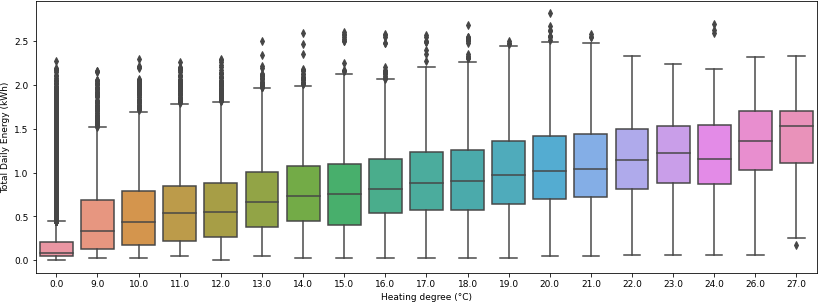

,heating_degree,median,mean,std,observations
0,0.0,0.0820,0.209884,0.292074,43864
1,9.0,0.3280,0.454186,0.396481,3744
2,10.0,0.4390,0.532965,0.414789,3936
3,11.0,0.5390,0.584772,0.431491,4224
4,12.0,0.5485,0.610677,0.428520,4992
5,13.0,0.6700,0.719333,0.437461,4032
6,14.0,0.7290,0.766523,0.437767,3552
7,15.0,0.7530,0.773078,0.467749,4800
8,16.0,0.8125,0.832156,0.445094,3744
9,17.0,0.8830,0.896028,0.464963,5764


In [27]:
# ------------------------
# DEFINE HELPER FUNCTION
# ------------------------

def calculate_heating_degree_day(df, temp_column='daily_avgtemp', room_temp=20.0, heating_limit_temp=12.0): 
  '''
      Calculates heating degree day values and adds them as additional column to the data frame.
      Args: 
          df_weather: data frame (must contain temperature readings)
          temp_column: string defining the column name of the average temperature value per day
          room_temp: assumed room temperature (in Switzerland, usually 20 degrees Celsius)
          heating_limit_temp: heating limit temperature (in Switzerland, usually 12 degrees Celsius)
      Returns: 
          the given data frame with an additional column
  '''
  df = df.copy()
  df['heating_degree'] = np.where(df[temp_column] < heating_limit_temp, room_temp - df[temp_column], 0)
  df.loc[df[temp_column].isnull(), 'heating_degree'] = np.nan
  return df

# ------------------------
# APPLY CALCULATIONS
# ------------------------

# calculate the degree day for each observation 
df_hd = calculate_heating_degree_day(df_combined, temp_column='daily_avgtemp', room_temp=20.0, heating_limit_temp=12.0)

# calculate correlation of energy with heating degree 
corr = stats.pearsonr(df_hd['Value'], df_hd['heating_degree'])
print('Correlation of energy with heating degree:', np.round(corr[0], 3))

# plot bot plots that group the observations over degree days
fig, ax = plt.subplots(figsize=(14, 5))
sns.boxplot(data=df_hd, x='heating_degree', y='Value', ax=ax)
ax.set_xlabel('Heating degree (°C)')
ax.set_ylabel('Total Daily Energy (kWh)')
plt.show()

# group the observations by degree day and calculate statistics for each degree day
df_median = df_hd.groupby(by=['heating_degree']).median().reset_index()[['heating_degree', 'Value']].rename(columns={'Value': 'median'})
df_mean = df_hd.groupby(by=['heating_degree']).mean().reset_index()[['heating_degree', 'Value']].rename(columns={'Value': 'mean'})
df_std = df_hd.groupby(by=['heating_degree']).std().reset_index()[['heating_degree', 'Value']].rename(columns={'Value': 'std'})
df_count = df_hd.groupby(by=['heating_degree']).count().reset_index()[['heating_degree', 'Value']].rename(columns={'Value': 'observations'})

# combine all statistics 
df_grouped = pd.merge(df_median, df_mean, on='heating_degree', how='left')
df_grouped = pd.merge(df_grouped, df_std, on='heating_degree', how='left')
df_grouped = pd.merge(df_grouped, df_count, on='heating_degree', how='left')
display(df_grouped)


You can now see above that instead of the previous negative correlations between energy and temperature, there is a **positive correlation between energy and heating degree day values**. You can also see from the boxplot and the table that as heating degree values increase, energy consumption increases but the number of observations decreases.

<a name=adding_time_information></a>
### **4.2 Add additional information for filtering timestamps**

In some cases, it may be beneficial to add **additional columns to the data frame describing the time of day or seasons, etc**, as this allows for improved filtering or grouping of the time series. We can add these columns by simply indexing the data frame.

In [28]:
# --------------------------------
# DEFINE HELPER FUNCTION
# --------------------------------

def add_descriptive_columns(df, basic=True, seasons=True, weekday=True, daytime=True): 
  '''
      Creates a copy of the SMD data frame and adds additional descriptive columns.
      NOTE: assumes that the timestamp is set as index of the data frame and is of type pd.datetime
      Args: 
          df: data frame holding the smart meter data 
          basic: boolean to set to True if very basic information should be added 
          seasons: boolean to set to True if the seasons should be added 
          weekday: boolean to set to True if distinction between weekend and weekday should be added 
          daytime: boolean to set to True if the time of day should be added (e.g. morning vs evening)
      Returns:
          processed copy of the data frame with additional columns
  '''

  # create a copy of the data frame as we do not want the original data to be affected
  df = df.copy()
  
  # add some basic columns
  df['date'] = df.index.date
  df['time_utc'] = df.index.tz_convert('UTC').time
  df['year'] = df.index.year
  df['month'] = df.index.month
  df['week'] = df.index.isocalendar().week
  df['dayOfWeek'] = df.index.dayofweek
  df['hour_utc'] = df.index.tz_convert('UTC').hour
  df['minute'] = df.index.minute

  # mapping months to seasons: 1- winter, 2-spring, 3-summer, 4-autumn 
  if seasons:
    seasons = {1: 1, 2: 1, 3: 2, 4: 2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1} # maps months to seasons: 
    df['season'] = df['month'].map(seasons, na_action=None)
    df['winter'] = np.where(df['season'] == 1, True, False)
    df['spring'] = np.where(df['season'] == 2, True, False)
    df['summer'] = np.where(df['season'] == 3, True, False)
    df['autumn'] = np.where(df['season'] == 4, True, False)
    df['transitionperiod'] = np.where((df['season'] == 2) | (df['season'] == 4), True, False)

  # mapping to descriptive times of the day
  if weekday:
    df['weekday'] = np.where(df['dayOfWeek'] <=4, True, False)
    df['weekend'] = np.where(df['dayOfWeek'] >=5, True, False)

  # add the time of day 
  if daytime:
    df['morning'] = np.where(df['hour_utc'].between(6, 10, inclusive='left'), True, False)
    df['noon'] = np.where(df['hour_utc'].between(10, 14, inclusive='left'), True, False)
    df['afternoon'] = np.where(df['hour_utc'].between(14, 18, inclusive='left'), True, False)
    df['evening'] = np.where(df['hour_utc'].between(18, 23, inclusive='left'), True, False)
    df['day'] = np.where(df['hour_utc'].between(6, 23, inclusive='left'), True, False)
    df['night'] = np.where((df['hour_utc'] >= 23) | (df['hour_utc'] < 6), True, False)

  if not basic: 
    df.drop(columns=['date', 'time_utc', 'year', 'month', 'week', 'dayOfWeek', 'hour_utc', 'minute'], inplace=True)
  return df

# --------------------------------
# APPLY HELPER FUNCTION
# --------------------------------

# let's add some information about the seasons
df_add = add_descriptive_columns(df_smd, basic=False, seasons=True, weekday=False, daytime=True)
display(df_add)

# now let's for example compare the mean consumption of summer vs. winter
print('Mean energy consumption in summer per 15 min:', np.round(df_add[df_add['summer']]['Value'].mean(), 3))
print('Mean energy consumption in winter per 15 min:', np.round(df_add[df_add['winter']]['Value'].mean(), 3))

,Value,Value_HeatPump,Value_OtherAppliances,season,winter,spring,summer,autumn,transitionperiod,morning,noon,afternoon,evening,day,night
Timestamp,,,,,,,,,,,,,,,
2019-11-20 00:00:00+01:00,0.736,0.682,0.054,4,False,False,False,True,True,False,False,False,False,False,True
2019-11-20 00:15:00+01:00,1.216,1.126,0.090,4,False,False,False,True,True,False,False,False,False,False,True
2019-11-20 00:30:00+01:00,0.488,0.450,0.038,4,False,False,False,True,True,False,False,False,False,False,True
2019-11-20 00:45:00+01:00,0.065,0.023,0.042,4,False,False,False,True,True,False,False,False,False,False,True
2019-11-20 01:00:00+01:00,0.650,0.608,0.042,4,False,False,False,True,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 22:45:00+02:00,0.052,0.000,0.052,3,False,False,True,False,False,False,False,False,True,True,False
2022-08-31 23:00:00+02:00,0.035,0.000,0.035,3,False,False,True,False,False,False,False,False,True,True,False
2022-08-31 23:15:00+02:00,0.031,0.000,0.031,3,False,False,True,False,False,False,False,False,True,True,False


Mean energy consumption in summer per 15 min: 0.164
Mean energy consumption in winter per 15 min: 0.912


<a name=normalization_methods></a>
### **4.3 Normalization methods**
For most tasks it is necessary to scale and normalize the smart meter data. The **type of normalization depends on the specific use case**. For example, if you want to compare energy consumption for heating different buildings, you can normalize by heated floor area or number of occupants (remember that this requires additional context information as described [earlier](#context_and_domain_knowledge)). Or if you want to compare energy consumption across different seasons, you should normalize by weather metrics.

However, many machine learning tasks often require zero mean and unit variance, which can be achieved by using [sklearn's StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

,Value,Value_HeatPump,Value_OtherAppliances,Value_Scaled
Timestamp,,,,
2019-11-20 00:00:00+01:00,0.736,0.682,0.054,0.424269
2019-11-20 00:15:00+01:00,1.216,1.126,0.090,1.385039
2019-11-20 00:30:00+01:00,0.488,0.450,0.038,-0.072129
2019-11-20 00:45:00+01:00,0.065,0.023,0.042,-0.918809
2019-11-20 01:00:00+01:00,0.650,0.608,0.042,0.252131
...,...,...,...,...
2022-08-31 22:45:00+02:00,0.052,0.000,0.052,-0.944829
2022-08-31 23:00:00+02:00,0.035,0.000,0.035,-0.978857
2022-08-31 23:15:00+02:00,0.031,0.000,0.031,-0.986863


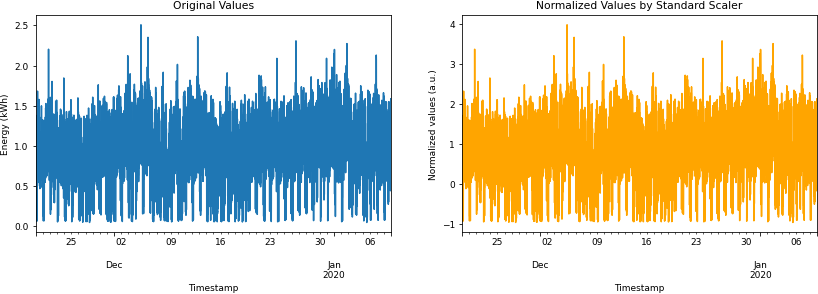

In [29]:
# ---------------------
# APPLY STANDARD SCALER
# ---------------------

# copy data to not affect original data
df_norm = df_smd.copy()

# apply standard scaler 
np_vals = df_smd['Value'].values.reshape(-1, 1)
scaler = StandardScaler().fit(np_vals)
np_vals = scaler.transform(np_vals)

# assign normalized values to new column 
df_norm['Value_Scaled'] = np_vals.flatten()
display(df_norm)


# ---------------------
# VISUALIZE RESULT
# ---------------------

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
days = 50
df_norm.iloc[:96*days]['Value'].plot(ax=ax[0])
df_norm.iloc[:96*days]['Value_Scaled'].plot(ax= ax[1], color='orange')
ax[0].set_title('Original Values')
ax[0].set_ylabel('Energy (kWh)')
ax[1].set_title('Normalized Values by Standard Scaler')
ax[1].set_ylabel('Normalized values (a.u.)')
plt.show()

You can **see above that** the shape of the data remains exactly the same, but that **the labels on the y-axis have changed** - so the data is scaled. In the same way, you can apply other common normalization methods provided by sklearn, such as:
- [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler)
- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)
- [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer)
- [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)
- [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

**For normalization by weather, we recommend, reading [this article](https://www.energylens.com/articles/degree-days).**

<a name=interpolation_methods></a>
### **4.4 Interpolation methods and downsampling**

If you want to analyze energy consumption by year, hour or day, for example, you have to **convert the data to a lower temporal resolution**. Basically, we just need to sum up the consumption over several timestamps. In pandas this can be done in a comparatively simple way by resampling the data.

In [30]:
# define the pandas keys for the most common resolution changes
resolution_dict = {
    'daily': '1D', 
    '30min' : '30min', 
    'hourly' : '1H', 
    'monthly' : '1M',
    'yearly' : '1Y' 
}

# choose your resolution and resample 
resolution = 'daily'
df_resampled = df_smd.resample(resolution_dict[resolution]).sum()
display(df_resampled)

,Value,Value_HeatPump,Value_OtherAppliances
Timestamp,,,
2019-11-20 00:00:00+01:00,82.463,40.091,42.372
2019-11-21 00:00:00+01:00,89.534,40.455,49.079
2019-11-22 00:00:00+01:00,84.448,41.784,42.664
2019-11-23 00:00:00+01:00,82.895,41.809,41.086
2019-11-24 00:00:00+01:00,73.950,39.631,34.319
...,...,...,...
2022-08-27 00:00:00+02:00,5.264,1.763,3.501
2022-08-28 00:00:00+02:00,4.567,1.044,3.523
2022-08-29 00:00:00+02:00,10.567,6.969,3.598


As mentioned [above](#data_availability), SMD may have **missing data due to interruptions in measurements or communication**.
It can be useful to **fill these gaps with interpolated values** based on the enclosing measurements.
Since this is a very common problem with time series, pandas has a built-in method for interpolation using different approaches.

Here we compare linear, polymomial and spline interpolation of a segment of the time series.

/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/3569989510.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


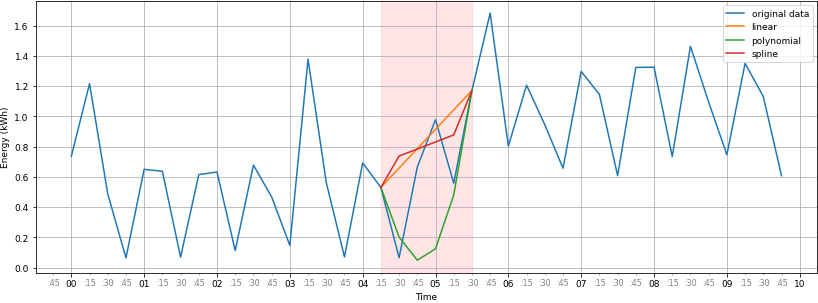

In [31]:
# take a segment of data points
start = 0
stop = 40
start_missing = 18
stop_missing = 22
excerpt = df_smd.iloc[start:stop].copy()

# remove data for 4 consecutive data points
missing = excerpt.copy()
missing['Value'].iloc[start_missing:stop_missing] = np.nan

# create figure
fig, ax = plt.subplots(figsize=(14, 5))

# plot different interpolations
ax.plot(excerpt['Value'], label='original data')
ax.plot(missing['Value'].interpolate().iloc[start_missing - 1:stop_missing + 1], label='linear')
ax.plot(missing['Value'].interpolate(method='polynomial', order=3).iloc[start_missing - 1:stop_missing + 1], label='polynomial')
ax.plot(missing['Value'].interpolate(method='spline', order=3).iloc[start_missing - 1:stop_missing + 1], label='spline')
ax.axvspan(excerpt.index[start_missing - 1], excerpt.index[stop_missing], color='red', alpha=0.1)

# additional formatting and show plot
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(range(15, 60, 15)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter(":%M"))
ax.tick_params(axis='x', which='minor', labelsize=8, colors='grey')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh)')
ax.legend()
fig.show()

You can see that the interpolated data does not quite match the original data points. The higher order polynomials in particular lead to large fluctuations in the interpolation.

Nonetheless, **interpolation can help deal with missing data**, especially when only short gaps of a single missing measurement are involved. As a more systematic test, we randomly remove 5% of the data **and apply different interpolation techniques**.
Here we see the strength of the interpolation. The mean absolute error between the interpolated and original data is consistently lower than when we naively fill in missing data with zero.

In [32]:
# we randomly remove 5% of the data
indices = np.random.choice(len(df_smd.index), size=int(0.05 * len(df_smd.index)), replace=False)
masked_df = df_smd['Value'].copy()
masked_df[indices] = np.nan

# define the parameters for the different interpolations
parameters = [
    {'method': 'linear', 'order': None},
    {'method': 'polynomial', 'order': 3},
    {'method': 'polynomial', 'order': 5},
    {'method': 'spline', 'order': 3},
]

# calculate the mean absolute error of each interpolation
print('Mean absolute error: \n')
for d in parameters: 
  print(d['method'] + ':', np.round(mean_absolute_error(masked_df.interpolate(**d), df_smd['Value']), 4))

# for comparison simply fill with zero
print('fill zeros:', np.round(mean_absolute_error(masked_df.fillna(0), df_smd['Value']), 4))

Mean absolute error: 



ValueError: Input contains NaN.

<a name=outlier_detection_hampel></a>
### **4.5 Outlier detection with Hampel filter**

So far we have dealt with missing data due to errors, but these errors can also lead to wrong data or wrong conclusions.
**Outlier detection methods are suitable for detecting unrealistic measurements.**

**Hampel filtering** is such a method to detect outliers based on a sliding window approach in which data points are compared to the distribution of their neighbors.
The method has two parameters:
- `window size` controls the size of the neighborhood to be considered for the distribution
- `n_sigmas` determines how far out of the distribution a point must fall, to be considered an outlier

Together, the parameters can be used to set the aggressiveness of the filtering. When a data point is detected as an outlier, its value is replaced by the median of its neighbors' distribution.

Share of outliers in the series: 0.005555555555555556


/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/213621637.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


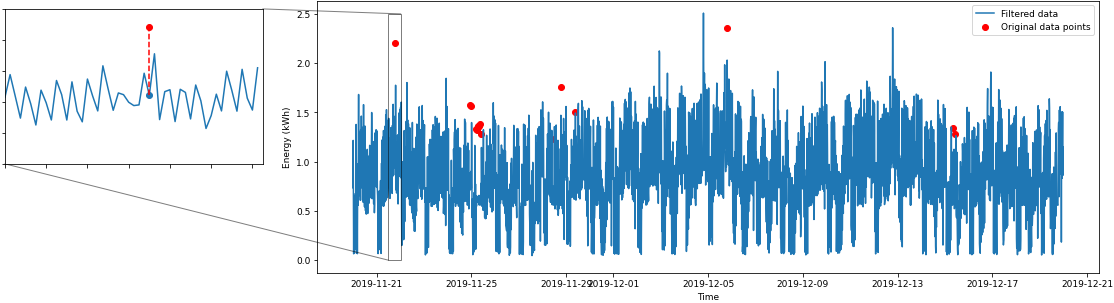

In [33]:
# ------------------------
# DEFINE HELPER FUNCTION
# ------------------------

def hampel_filter(series, window_size, n_sigmas=3):
  '''
  Implementation based on https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d
  '''
  k = 1.4826  # scale factor for Gaussian distribution

  # make a new series in which we overwrite the outliers
  new_series = series.copy()

  # calculate the median of the data in the neighborhood
  rolling_median = series.rolling(window=2 * window_size, center=True).median()

  # calculate the median absolute difference to estimate the spread of the distribution
  rolling_mad = k * series.rolling(window=2 * window_size, center=True).apply(
      lambda x: np.median(np.abs(x - np.median(x)))
  )

  # calculate the deviation of each point from the median
  diff = np.abs(series - rolling_median)

  # select values that deviate more than n_sigma from the mad and replace them with the median
  mask = diff > (n_sigmas * rolling_mad)
  new_series[mask] = rolling_median[mask]

  print('Share of outliers in the series:', mask.mean())

  return new_series, mask

# -----------------
# APPLY FILTERING
# -----------------

# apply filter to one month of data
excerpt = df_smd['Value'].iloc[:96 * 30]
filtered, mask = hampel_filter(excerpt, 15)


fig, ax = plt.subplots(figsize=(14, 5))
# plot the filtered time series
ax.plot(filtered, label='Filtered data')
# plot dots for the filtered out data
ax.scatter(excerpt.index[mask], excerpt[mask], c='r', label='Original data points')
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh)')
ax.legend()

# Magnify a section of the data
start = int(1.5 * 96)
stop = start + 50
axins = ax.inset_axes([-0.4, 0.4, 0.33, 0.57])
# plot the filtered data
axins.plot(filtered.index[start:stop], filtered[start:stop])
axins.scatter(excerpt.index[mask], filtered[mask])
# plot the original data
axins.scatter(excerpt.index[mask], excerpt[mask], c='r')
axins.plot([excerpt.index[mask][0], excerpt.index[mask][0]],
           [filtered[mask][0], excerpt[mask][0]], ls='--', c='r')

axins.set_xlim(excerpt.index[start], excerpt.index[stop])
axins.set_ylim(0, 2.5)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black")

fig.show()

<a name=simple_baseload_estimation></a>
### **4.6 Simple baseload estimation**

The term **baseload refers to the minimum amount of electricity that a household or building uses on a fairly continuous basis**. It is independent of whether or not someone is actively using appliances or electronics. For example, it can be caused by heating and cooling systems, refrigerators, or other major appliances that run continuously even when no one is home. Normally, the baseload is relatively stable from day to day with only minor fluctuations. Estimating baseload can be beneficial for energy conservation initiatives or for identifying unusual spikes to detect device failures, leaks, or other issues that may need attention.

In the following, we **estimate the baseload** of the given smart meter data using a **simple distribution-based approach with the following steps:**
- first, we sort all energy observations in ascending order
- then we decide on a certain percentage (20% by default) of the smallest values to be considered for the calculation 
- then we calculate the mean and standard deviation of the values to be considered 
- Finally, we define the baseload as the first value above the mean plus three times the calculated standard deviation.

Estimated baseload: 0.084


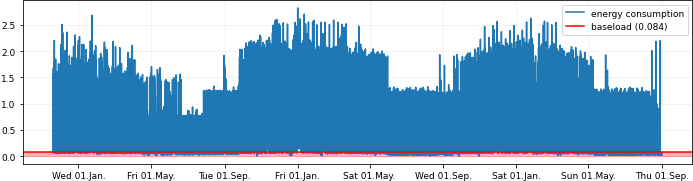

In [35]:
# ------------------------
# DEFINE HELPER FUNCTION
# ------------------------

def estimate_baseload(df, val_share_included=0.2):
  '''
      Estimates the standby-/baseload of a data frame containing smart meter data.
      Baseload is assumed to be the first kWh-value of whole df that is > mean+3*std of ascendingly sorted kWh values to be considered (as given by val_share_included)
      Args: 
          val_share_included: percentage of ascendingly sorted kWh-values to be considered for calculating mean and std
      Returns: 
          float representing the calculated baseload
  ''' 
  
  # NOTE: current approach is rather naive and suitable for aggregated smart meters 

  # copy the data frame and sort it ascendingly
  df_sorted = df.copy().sort_values(by='Value', ascending=True)

  # decide for the cut-off of values to be considered 
  stop_index = math.ceil(val_share_included * len(df))

  # calculate mean and standard deviation
  mean = df_sorted[:stop_index]['Value'].mean()
  std = df_sorted[:stop_index]['Value'].std()

  # estimate the baseload and return it as rounded value
  baseload = df_sorted[df_sorted['Value'] > mean+3*std]['Value'].iloc[0]
  return round(baseload, 4) 

# ------------------------
# APPLY BASELOAD ESTIMATION
# ------------------------

# estimate the baseload 
baseload = estimate_baseload(df_smd, val_share_included=0.2)
print('Estimated baseload:', baseload)

# ------------------------------------
# PLOT ENERGY CONSUMPTION AND BASELOAD
# ------------------------------------

# let's see what this looks like in a plot 
fig, ax = plt.subplots(figsize=(12,3))
df_sub = add_descriptive_columns(df_smd, seasons=True)
days = 7
df_sub = df_sub[df_sub['winter']].iloc[:96*days]
ax.plot(df_smd['Value'], label='energy consumption')
ax.axhline(y=baseload, color='red', label='baseload ({})'.format(baseload))
ax.axhspan(ymin=0, ymax=baseload, color='red', alpha=0.3)
ax.legend()
ax.grid(alpha=0.2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%b."))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

<a name=small_activities></a>
### **4.7 Enhancing small activities**
We can use the baseload calculated above as a threshold to filter out all measured values that are smaller. 
However, for some applications, just the opposite may be necessary or beneficial. 
For example, devices such as LED light bulbs, laptops, smartphones, or tablets tend to consume little power compared to other large loads such as heat pumps. 
Alternatively, we can **enhance small activities by applying a transformation function to the energy values**. 
The function should **compress large values and expand small numbers relatively**. 
This may result in less skewed values (especially for distributions with long tail ends), but requires an additional step to interpret the transformed energy measurements (since the inverse transform should be applied before interpretation).  

In general, the selection of an appropriate transformation function depends on the application. 
In the [additional resources section](#resources_other), we provide some links to external guidance as a possible starting point. 
However, in our experience, the **square root transformation works particularly well for energy data**. 
Let's take a look at the data before and after the transformation. 
You should see that the activities caused by the heat pump controller with comparatively low power consumption are now enhanced.

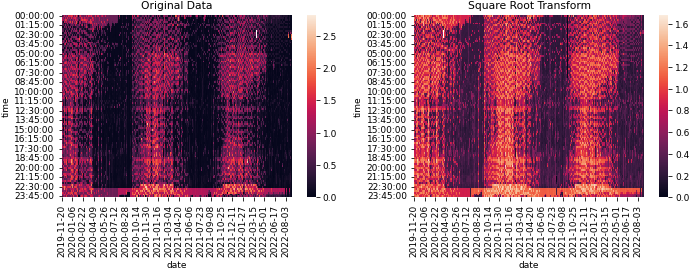

In [37]:
#----------------------
# APPLY TRANSFORMATION
#----------------------

# apply square root transformation
df_sqrt = np.sqrt(df_smd)

#--------------------------------
# CREATE HEATMAPS FOR COMPARISON
#--------------------------------
# NOTE: we use the heatmap function introduced earlier

# create figure 
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# first plot 
sns.heatmap(create_heatmap(df_smd, column='Value'), ax=ax[0])
ax[0].set_title('Original Data')

# second plot
sns.heatmap(create_heatmap(df_sqrt, column='Value'), ax=ax[1])
ax[1].set_title('Square Root Transform')

plt.tight_layout()
plt.show()

<a name=detecting_switching_activities></a>
### **4.8 Detecting switching activities**

Let us use the square-root transformed data to **identify the switching events** caused by the heat pump. A **simple algorithm** for finding prominent switching events is presented in [7]. It **proceeds as follows:** 
1. for each time $t$ the difference of the consumption to $t-2$ is calculated - let us call the resulting values *second differences*. 
2. a positive value of the second difference can now be interpreted as a switch-on event that must have occurred between the last two measurements, and a negative value refers to a switch-off event. A value close to zero indicates an insignificant change in consumption, e.g. measurement errors, which we may wish to neglect.
2. applying a peak detection to the second difference allows to distinguish between prominent and non-prominent switching operations.

Let's implement this in Python using [scipy's peak detection algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html).

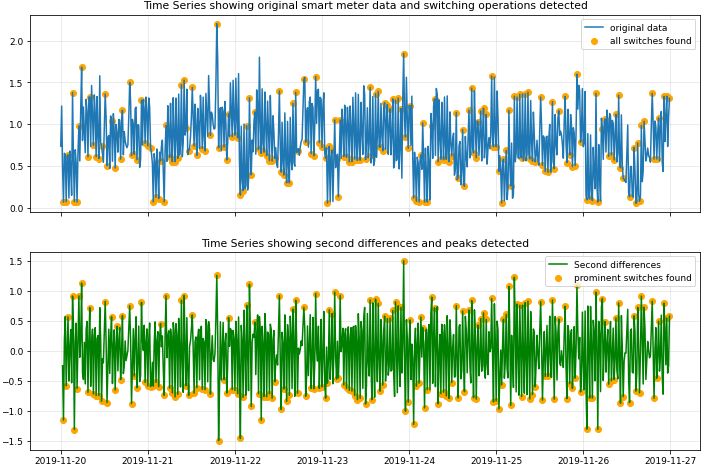

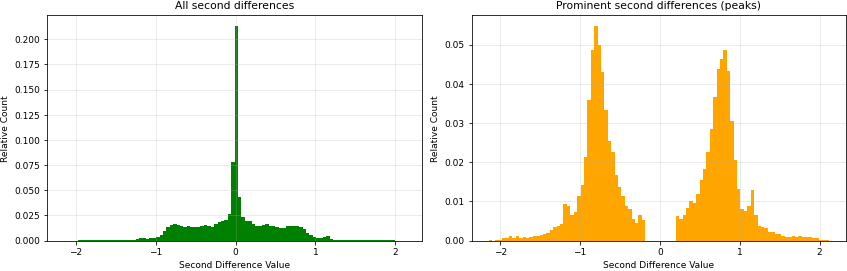

In [38]:
#------------------------
# DEFINE HELPER FUNCTIONS
#------------------------

def calculate_second_differences(df, column='Value'): 
  '''
      Calculates the difference of consumption of measurement t0 to t-2 and assigns it to time point t0. 
      Adds these as separate column to the data frame - column named second_diff
      Args: 
          df: data frame to be analyzed containing smart meter data 
      Returns: 
          returns copy of df where a new column named "second_diff" is available
              NOTE: first two values are NAN, because for these the previous measurements to not exist
  '''
  # copy data frame as original data should not be affected
  df = df.copy()
  # get consumption as vector
  np_cons = df[column].values
  # shift the consumption by two indices 
  np_cons_shifted = np.roll(np_cons, 2)
  # subtract the shifted vector from the original one
  np_diff = np_cons - np_cons_shifted
  # replace the first two elements by NAN because there were actually no measurements to be subtracted
  np_diff[:2] = np.nan
  # add the differences again to the data frame 
  df['second_diff'] = np_diff
  
  return df

def calculate_peaks_on_second_differences(df, prominence=None): 
    '''
        Calculates the peaks on the second differences and adds a boolean indication as separate column called second_diff_peak.
        NOTE: it uses the absolute values of the differences to calculate peaks because the peak detection would ignore local minima.
        Args: 
            df: data frame holding the calculated second difference values (assumed to be in column named second_diff)
            prominence: prominence parameter as defined in scipy.signal.find_peaks
        Returns: 
            copy of df with additional column "second_diff_peak"
    '''
    
    # copy data frame as original data should not be affected
    df = df.copy()
    # get the local extrema on the absolute differences by peak detection 
    np_peaks_indices = find_peaks(np.abs(df['second_diff'].values), prominence=prominence)[0]
    # mark in original data frame if the value is a peak or not 
    df['second_diff_peak'] = False
    df.loc[df.iloc[np_peaks_indices].index, 'second_diff_peak'] = True
    return df

#------------------------
# APPLY SWITCHING DETECTION
#------------------------

# apply the second differences calculation 
df_diff = calculate_second_differences(df_smd)

# apply peak detection to second differences 
df_diff = calculate_peaks_on_second_differences(df_diff, prominence=0.2)

#-------------------------------------------
# PLOT TIMESERIES WITH IDENTIFIED SWITCHINGS
#-------------------------------------------

# create figure 
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# select indices and values of found peaks 
days = 7
df_sub = df_diff.iloc[:96*days]
indices = df_sub[df_sub['second_diff_peak']].index
peak_vals = df_sub.loc[indices, 'Value'].values
diff_vals = df_sub.loc[indices, 'second_diff'].values

# first plot: original time series
ax[0].plot(df_sub['Value'], label='original data')
ax[0].scatter(indices, peak_vals, color='orange', label='all switches found') # mark the found peaks 
ax[0].legend()
ax[0].grid(alpha=0.3)
ax[0].set_title('Time Series showing original smart meter data and switching operations detected')

# second plot: second differences
ax[1].plot(df_sub['second_diff'], label='Second differences', color='green')
ax[1].scatter(indices, diff_vals, color='orange', label='prominent switches found') # mark the found peaks 
ax[1].legend()
ax[1].grid(alpha=0.3)
ax[1].set_title('Time Series showing second differences and peaks detected')

plt.show()

#------------------------
# PLOT DISTRIBUTIONS
#------------------------

# create figure 
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the distributions of all second differences 
np_diff = df_diff['second_diff'].values
weights = np.ones(len(np_diff)) / len(np_diff)
ax[0].hist(np_diff, bins=100, weights=weights, color='green')
ax[0].set_xlabel('Second Difference Value')
ax[0].set_ylabel('Relative Count')
ax[0].grid(alpha=0.3)
ax[0].set_title('All second differences')

# plot the distributions of only of the peak second differences 
np_diff = df_diff[df_diff['second_diff_peak']]['second_diff'].values
weights = np.ones(len(np_diff)) / len(np_diff)
ax[1].hist(np_diff, bins=100, weights=weights, color='orange')
ax[1].set_xlabel('Second Difference Value')
ax[1].set_ylabel('Relative Count')
ax[1].grid(alpha=0.3)
ax[1].set_title('Prominent second differences (peaks)')

plt.tight_layout()
plt.show()

<a name=sliding_window_approaches></a>
### **4.9 Sliding window approaches**
Without going into depth here, **a common approach for working with time series data is to use a sliding window**. A window is assigned a width (example below with width 3) and then slid over the time series with a fixed step size (example below with step size 1). In each window, an operation can be performed (e.g. average, sum or more complex calculations).

| 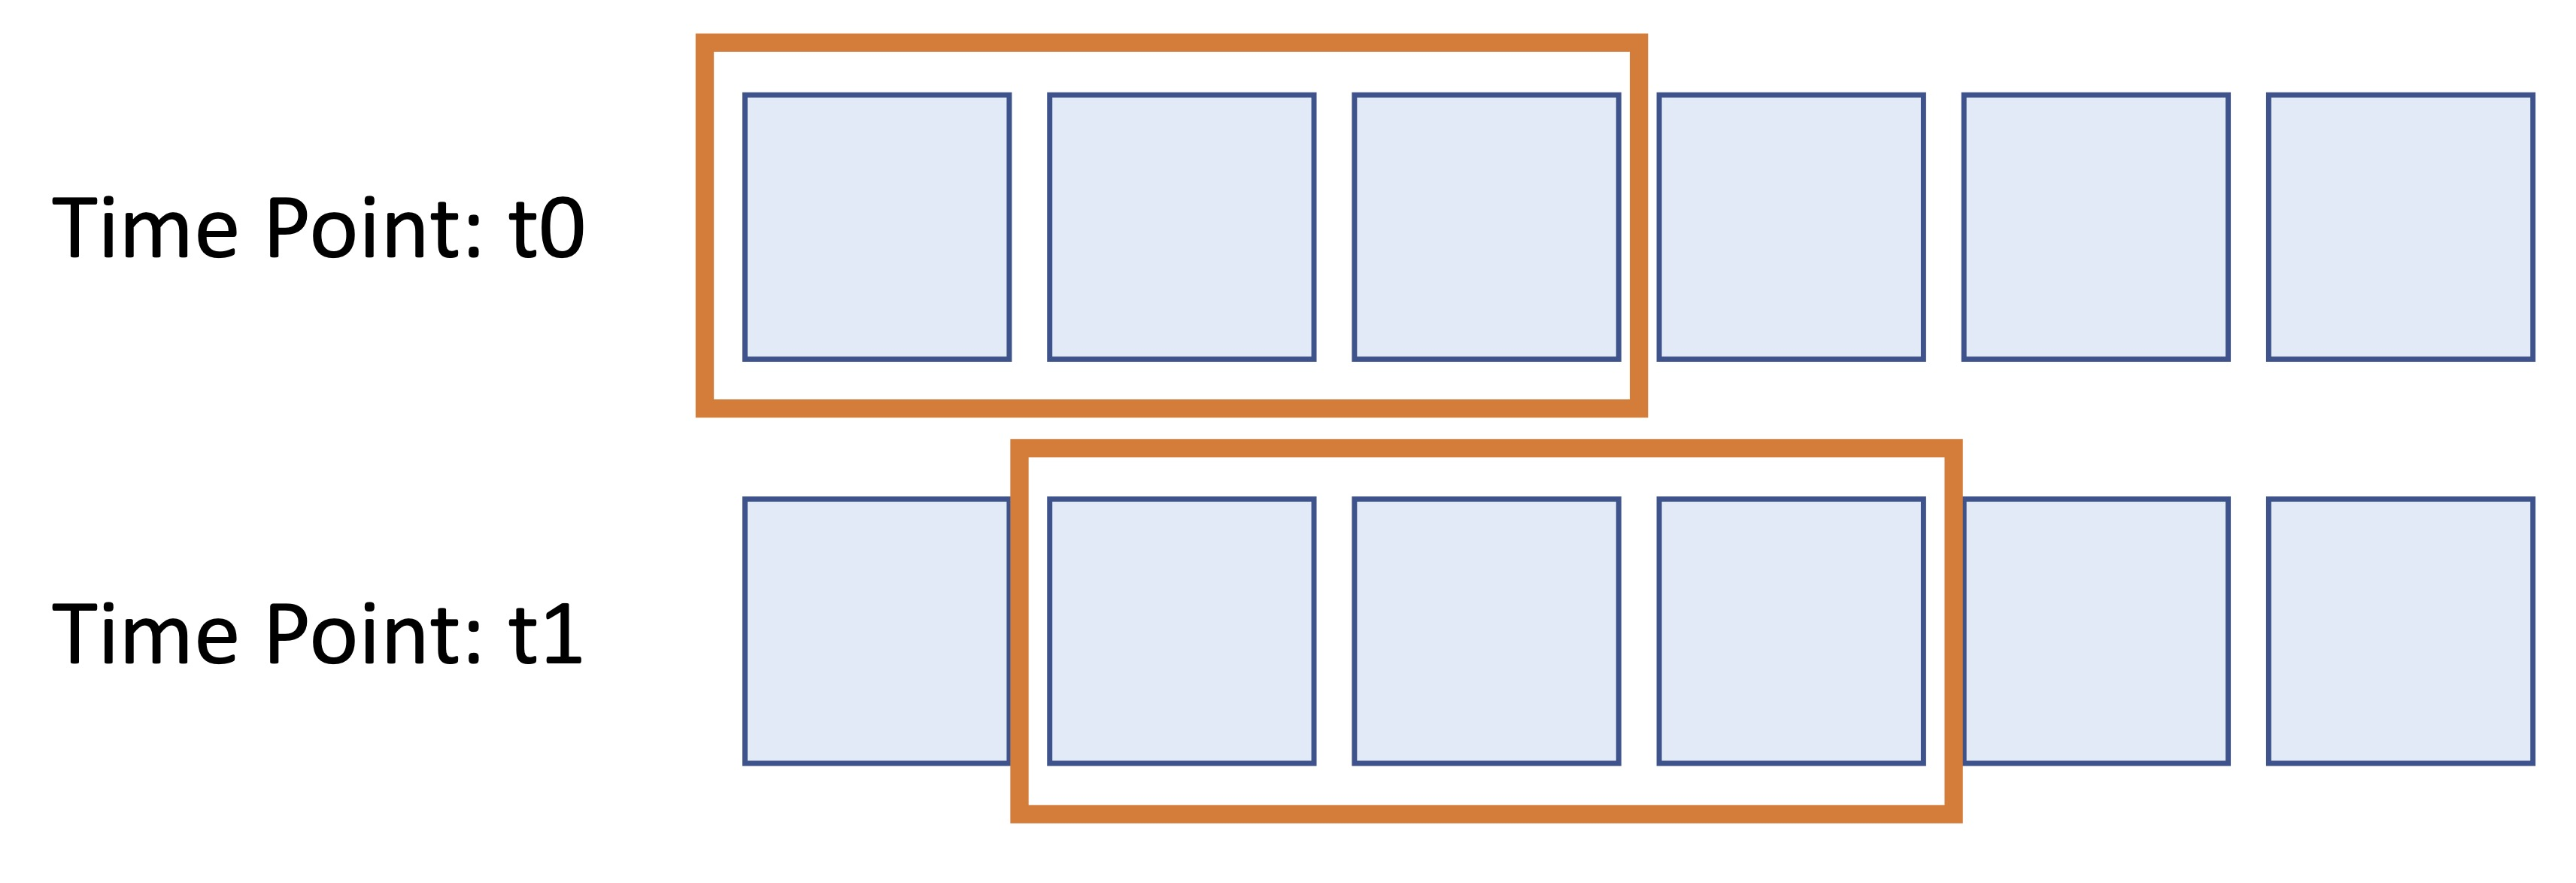 | 
|:--:| 
| *Source: Own figure.* |

An easy way to apply a sliding window to smart meter data is to use the [pandas internal rolling function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html). Pandas also provides a [window operations guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html) online. Below is a **basic example**:

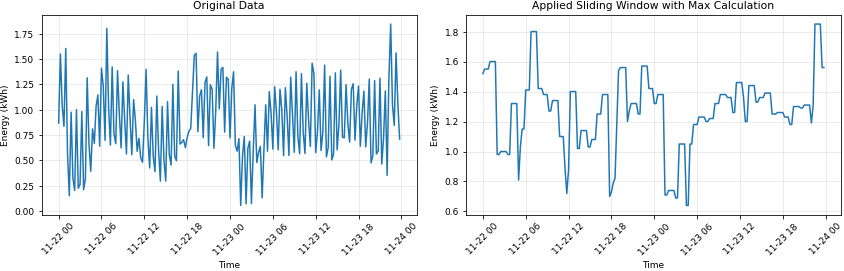

In [39]:
# select a window size
window_size = 4

# apply a sliding window with maximum calculation (i.e. rolling mean)
df_sliding = df_smd.rolling(window_size).max().round(2)

# create figure to show the time series before and after sliding window
fig,ax = plt.subplots(1, 2, figsize=(12, 4))

# plot original data
plot_data(ax[0], df_smd.iloc[192:384])
ax[0].set_title('Original Data')
ax[0].grid(alpha=0.3)

# plot sliding window data
plot_data(ax[1], df_sliding.iloc[192:384])
ax[1].set_title('Applied Sliding Window with Max Calculation')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

<a name=feature_extraction></a>
### **4.10 Feature extraction**

Many machine learning algorithms are not designed to deal with time series as input. Instead, **features can be extracted that describe the time series and can serve as input to the algorithms**. This usually also has the advantage of **dimensionality reduction**. For example, clustering or classification algorithms such as K-nearest neighbor or random forest do not work well with the original time series, but with previously extracted features. In general, choosing the appropriate features depends on your use case and often requires expertise. The best question to ask yourself is: *What do I want to achieve, and how does one household's data differ from another?*. However, you can start with a **well-known Python package called [tsfresh](https://github.com/blue-yonder/tsfresh)**. It is **easy to use and is designed for extracting features from arbitrary time series**. Below we show you what this looks like.

- **NOTE:** If you are interested, you can also use tsfresh to [define your own features](https://tsfresh.readthedocs.io/en/latest/text/how_to_add_custom_feature.html) or [check the meaning of features and select them accordingly](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_selection.html). 
- **NOTE:** In [one of the upcoming sections on load forecasting](#load_forecasting), we refer to a [separate CCAI tutorial](https://colab.research.google.com/drive/1ZWpJY03xLIsUrlOzgTNHemKyLatMgKrp?usp=sharing). This reference tutorial explains that *time* can also serve as a feature, but this requires special treatment so that it has cyclic properties. Please refer to the tutorial if you want to use the time variable as input to a model.

In [40]:
# copy the smart meter data to not affect the original data 
df_copy = df_smd.copy()

# make sure that the data frame is sorted 
df_copy.sort_index(inplace=True)

# NOTE: tsfresh requires an ID-column to know which time series refers to which ID
# hence you could also combine the features extraction for data of multiple smart meters 
# but here let's add the date as separate column and use it as ID to extract daily features
df_copy['date'] = df_copy.index.date

# for the sake of speeding up the process, let's select ten random days and remove the rest 
dates = df_copy['date'].unique()
dates = np.random.choice(dates, size=10)
df_copy = df_copy[df_copy['date'].isin(dates)]

# now extract all available features 
df_features = tsfresh.extract_features(df_copy, column_id='date', show_warnings=False, disable_progressbar=True) 
print('Number of extracted features:', len(df_features.columns.values))

# show the feature data frame 
display(df_features)

Number of extracted features: 2364


,Value__variance_larger_than_standard_deviation,Value__has_duplicate_max,Value__has_duplicate_min,Value__has_duplicate,Value__sum_values,Value__abs_energy,Value__mean_abs_change,Value__mean_change,Value__mean_second_derivative_central,Value__median,...,Value_OtherAppliances__fourier_entropy__bins_5,Value_OtherAppliances__fourier_entropy__bins_10,Value_OtherAppliances__fourier_entropy__bins_100,Value_OtherAppliances__permutation_entropy__dimension_3__tau_1,Value_OtherAppliances__permutation_entropy__dimension_4__tau_1,Value_OtherAppliances__permutation_entropy__dimension_5__tau_1,Value_OtherAppliances__permutation_entropy__dimension_6__tau_1,Value_OtherAppliances__permutation_entropy__dimension_7__tau_1,Value_OtherAppliances__query_similarity_count__query_None__threshold_0.0,Value_OtherAppliances__mean_n_absolute_max__number_of_maxima_7
2020-03-18,0.0,0.0,0.0,1.0,52.038,47.237836,0.332326,0.005421,-0.003426,0.4415,...,0.367614,0.562884,2.127786,1.720805,2.901958,3.837728,4.312817,4.484406,NaN,0.722571
2020-03-26,0.0,0.0,0.0,1.0,82.324,90.215974,0.400537,0.002116,0.002830,0.9040,...,0.437189,0.659812,2.106658,1.740466,3.046728,4.107260,4.368003,4.453600,NaN,0.746571
2020-07-13,0.0,0.0,0.0,1.0,14.399,6.333815,0.054084,-0.000253,0.000000,0.0645,...,1.391543,2.013147,3.424730,1.673283,2.823007,3.785330,4.291833,4.484406,NaN,0.248571
2020-11-18,0.0,0.0,0.0,0.0,83.266,90.072452,0.395474,0.004568,-0.005160,0.8505,...,0.297586,0.297586,1.773885,1.648615,2.723707,3.694604,4.274584,4.422793,NaN,0.934000
2021-01-07,0.0,0.0,0.0,1.0,105.670,137.929150,0.423642,0.014526,0.001362,1.0735,...,0.398219,0.739032,2.239993,1.761945,2.937731,3.821592,4.346259,4.438197,NaN,1.259143
2021-03-12,0.0,0.0,0.0,0.0,67.598,64.610988,0.385895,0.004063,-0.009979,0.6195,...,0.784817,1.013072,2.059200,1.689822,2.876003,3.827594,4.230897,4.401576,NaN,0.620429
2021-09-08,0.0,0.0,0.0,1.0,13.171,6.973785,0.076337,-0.000463,-0.004606,0.0495,...,0.564258,0.916105,2.766533,1.678273,2.781167,3.718880,4.255615,4.438197,NaN,0.288714
2021-09-17,0.0,1.0,0.0,1.0,20.183,11.749461,0.086842,0.012884,-0.000117,0.1195,...,0.468704,0.941229,2.765447,1.743194,2.987937,3.930132,4.307067,4.453600,NaN,0.455714
2022-05-18,0.0,0.0,0.0,1.0,12.436,5.527992,0.071884,0.000558,0.000718,0.0545,...,1.135624,1.739576,3.271181,1.702359,2.879001,3.933073,4.373753,4.484406,NaN,0.164429
2022-08-21,0.0,0.0,0.0,1.0,12.299,5.204613,0.076905,0.000400,-0.000415,0.0635,...,1.074858,1.702284,3.389504,1.738207,2.974690,3.947195,4.352769,4.484406,NaN,0.168286


<a name=distributional_peak_detection></a>
### **4.11 Detecting peaks in distribution**

In the previous section, we explained how to extract features from the time series to use as input for other algorithms. 
Here we note that the **distribution** of values (e.g., shown as a histogram below) can also serve as a feature and direct input for machine learning methods.
In the context of smart meter data analytics, the distribution of energy measurements is particularly valuable because it can **provide an indication of the potential number of relevant appliances**. 
If a device has a power consumption that is significantly different from other devices, and if the device is regularly active, it will show up as a peak in the distribution. 

As an **example**, we identify peaks in the distribution below and highlight the areas around them. 
We note that, in general, each measurement can be marked as belonging to one of the peaks and thus to a potential device, which would allow monitoring of their running times in a later step.
However, we also emphasize that in the case of many devices with overlapping power consumption, the approach of finding maxima in the distribution can lead to erroneous conclusions. 

/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/2258309882.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


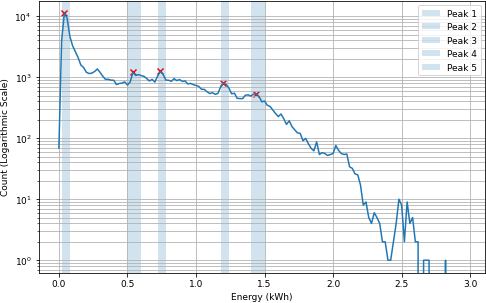

In [41]:
# define the bin width and number of bins of histogram
binwidth = 0.02  # kWh
bins = np.arange(0, 3, binwidth)

# calculate the distribution of energy values
df_smd_hist, _ = np.histogram(df_smd['Value'], bins=bins)

# require width of 2.5*0.02kWh = 50Wh
peaks, peak_properties = find_peaks(df_smd_hist, prominence=3, width=2.5)

# create figure 
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(bins[:-1], df_smd_hist)

# mark regions around peaks in blue
i = 1
for p, w in zip(peaks, peak_properties['widths']):
  ax.axvspan(bins[int(p - w / 2) + 1], bins[int(p + w / 2) + 1], alpha=0.2, label='Peak {}'.format(i))
  i += 1

# mark peaks with read cross
ax.scatter(bins[peaks], df_smd_hist[peaks], color='red', marker='x')

# adjust formatting and show figure
ax.set_yscale('log')
ax.grid(which='both')
ax.legend()
ax.set_xlabel('Energy (kWh)')
ax.set_ylabel('Count (Logarithmic Scale)')
fig.show()

<a name=frequency_based_methods></a>
### **4.12 Frequency-based methods for low-resolution data**

Frequency-based methods are a useful way to unveil regular patterns in data.
**By applying a Fast Fourier transform to the smart meter data**, the energy signal can be transformed from the time domain to the frequency domain. This way the regularity of a signal can be observed.

Below, you find an **example how to calculate the frequency spectrogram over the entire observation period**. Here, the spectogram shows the periodic peaks in the real part and a pronounced rise in amplitude at a period of 45 min (0.75h) to 1h. This activity can especially be observed in winter because it is caused by the heat pump.

/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/111511251.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/bn/87f_6s4d0mz75bj54jfql33h0000gn/T/ipykernel_23110/111511251.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


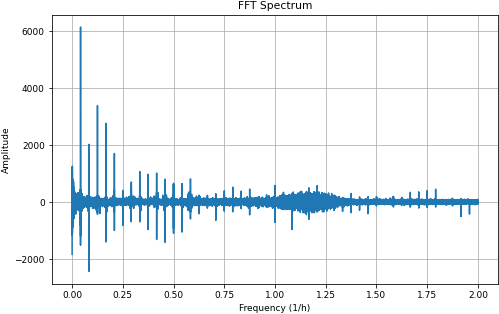

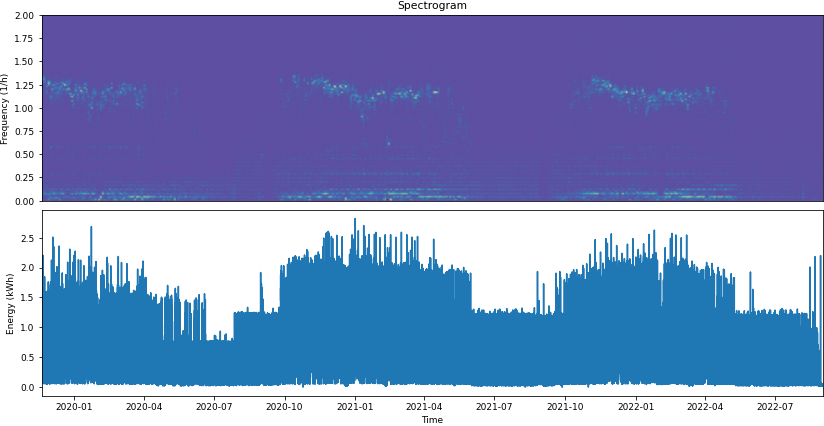

In [42]:
from scipy.fft import fft, fftfreq
from scipy import signal

# define time sampling interval in hours
T = 0.25

# calculate fft
yf = fft(df_smd['Value'].to_numpy()).real
# calculate fft frequencies
xf = fftfreq(len(df_smd), T)[:len(df_smd) // 2]

# plot fft (excluding fist data point)
fig, ax = plt.subplots()
ax.plot(xf[1:len(df_smd) // 2], yf[1:len(df_smd) // 2])
ax.set_xlabel('Frequency (1/h)')
ax.set_ylabel('Amplitude')
ax.set_title('FFT Spectrum')
ax.grid()
fig.show()

# plot spectrogram
fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=False)
# sample frequency in 1 / hours
fs = 1 / 0.25
f, t, Sxx = spectrogram(df_smd['Value'].to_numpy(), fs)
ax[0].pcolormesh(t, f, Sxx, shading='gouraud', cmap='Spectral_r')
ax[0].set_ylabel('Frequency (1/h)')
ax[0].set_title('Spectrogram')
ax[0].set_xticks([])
# plot original data for comparison
ax[1].plot(df_smd['Value'])
ax[1].set_xlim(df_smd.index[0], df_smd.index[-1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy (kWh)')

fig.subplots_adjust(hspace=0.05)
fig.show()